--- Loading data ---
--- Preprocessing data ---
History data range: 2024-07-11 to 2024-07-20
Problem 4 Prediction date: 2024-07-23
Data loaded and preprocessed.

--- Visualizing Historical Data Overview ---
Plot saved as Historical_User_Behavior_Distribution.pdf


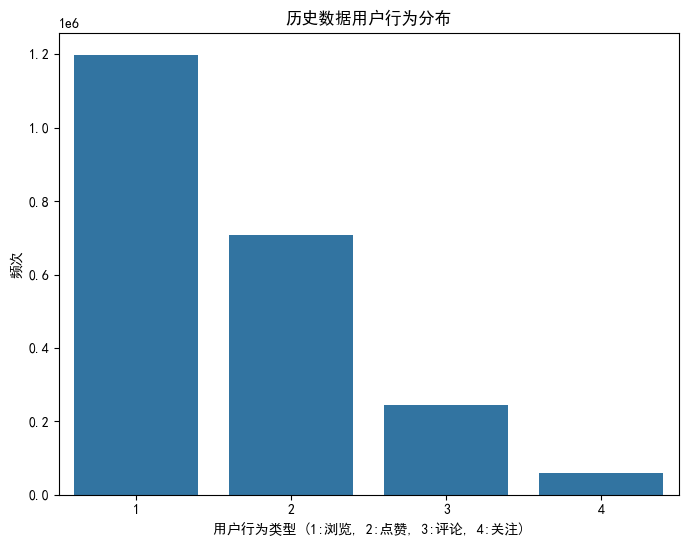

Plot saved as Historical_Daily_Interactions_Trend.pdf


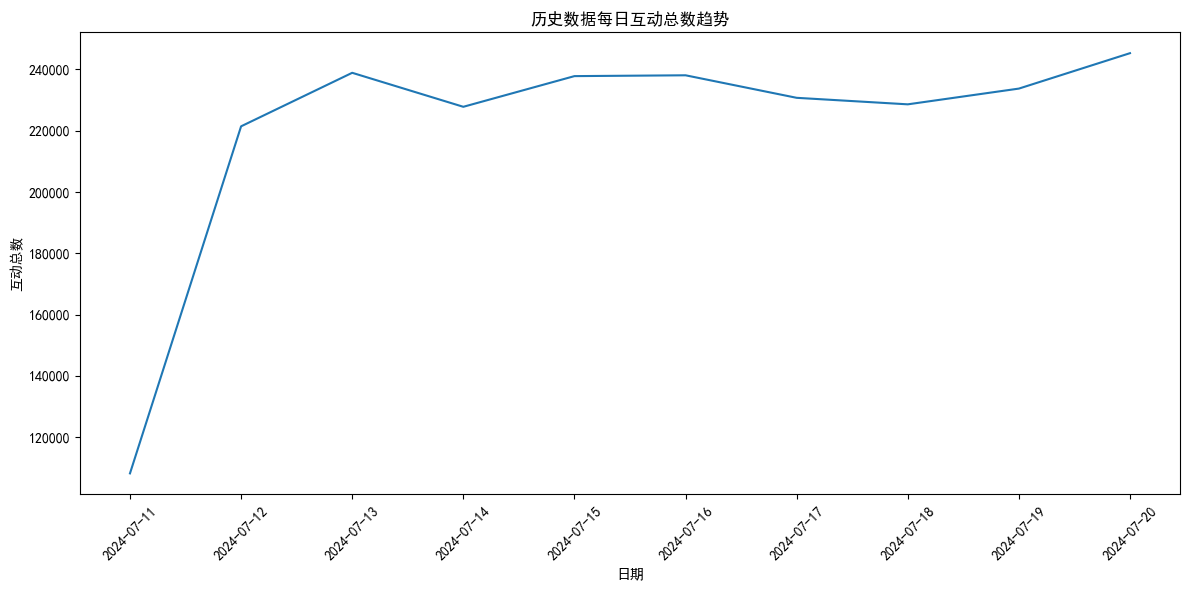

Plot saved as Historical_Hourly_Distribution.pdf


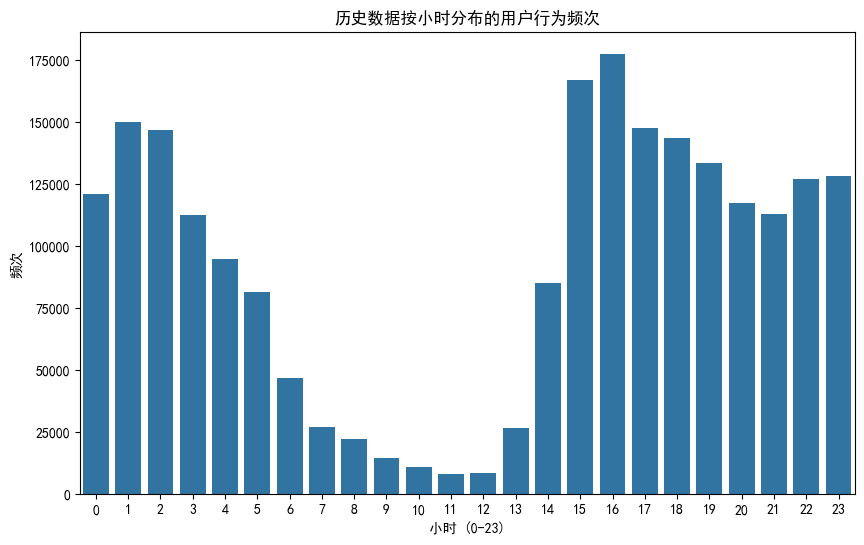

28222

In [11]:
import pandas as pd
import numpy as np
import lightgbm as lgb

# from tqdm import tqdm # 如果在普通python脚本环境
from tqdm.notebook import tqdm  # 如果在notebook环境，使用这个导入
import gc
import warnings
from datetime import timedelta
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    auc,
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# 设置 matplotlib 字体以支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用一个常见的中文宋体字体，如果 SimHei 不可用，可以尝试 'Microsoft YaHei' 等
plt.rcParams['axes.unicode_minus'] = False # 确保负号正常显示


# --- 1. 数据加载与预处理 ---
print("--- Loading data ---")
dtype_spec = {
    "UserID": "category",
    "UserBehaviour": "int8",
    "BloggerID": "category",
    "Time": "str",
}

# Problem 4只需要附件1的数据
try:
    # 直接使用相对或绝对路径
    # 请根据实际文件路径修改这里
    df_hist = pd.read_csv(
        "/Users/pp/projects/51MCM2025/program/a1.csv", dtype=dtype_spec
    )
except FileNotFoundError:
    print("Error: 'a1.csv' not found. Please check the file path.")
    # 如果文件找不到，直接退出或者采取其他错误处理方式
    exit()  # 或者 raise FileNotFoundError("a1.csv not found")


print("--- Preprocessing data ---")
df_hist["Time"] = pd.to_datetime(df_hist["Time"])
df_hist["Date"] = pd.to_datetime(df_hist["Time"].dt.date)
df_hist["Hour"] = df_hist["Time"].dt.hour  # 提取小时用于时段分析

# --- 时间点定义 ---
hist_start_date = pd.to_datetime("2024-07-11")
hist_end_date = pd.to_datetime("2024-07-20")  # 历史数据截止日期
predict_date = pd.to_datetime("2024-07-23")  # 问题4预测目标日期

print(f"History data range: {hist_start_date.date()} to {hist_end_date.date()}")
print(f"Problem 4 Prediction date: {predict_date.date()}")

# Problem 4 目标用户列表
target_users_p4 = ["U10", "U1951", "U1833", "U26447"]

print("Data loaded and preprocessed.")

# --- 新增可视化：历史数据概览 ---
print("\n--- Visualizing Historical Data Overview ---")

# 1. 用户行为分布
plt.figure(figsize=(8, 6))
sns.countplot(x='UserBehaviour', data=df_hist)
plt.title('历史数据用户行为分布')
plt.xlabel('用户行为类型 (1:浏览, 2:点赞, 3:评论, 4:关注)')
plt.ylabel('频次')
pdf_filename_behavior_dist = "Historical_User_Behavior_Distribution.pdf"
plt.savefig(pdf_filename_behavior_dist, format='pdf', bbox_inches='tight')
print(f"Plot saved as {pdf_filename_behavior_dist}")
plt.show()

# 2. 每日互动总数趋势
daily_interactions = df_hist.groupby('Date').size().reset_index(name='count')
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='count', data=daily_interactions)
plt.title('历史数据每日互动总数趋势')
plt.xlabel('日期')
plt.ylabel('互动总数')
plt.xticks(rotation=45)
plt.tight_layout()
pdf_filename_daily_trend = "Historical_Daily_Interactions_Trend.pdf"
plt.savefig(pdf_filename_daily_trend, format='pdf', bbox_inches='tight')
print(f"Plot saved as {pdf_filename_daily_trend}")
plt.show()

# 3. 小时分布 (所有用户)
plt.figure(figsize=(10, 6))
sns.countplot(x='Hour', data=df_hist, order=sorted(df_hist['Hour'].unique()))
plt.title('历史数据按小时分布的用户行为频次')
plt.xlabel('小时 (0-23)')
plt.ylabel('频次')
pdf_filename_hourly_dist = "Historical_Hourly_Distribution.pdf"
plt.savefig(pdf_filename_hourly_dist, format='pdf', bbox_inches='tight')
print(f"Plot saved as {pdf_filename_hourly_dist}")
plt.show()

gc.collect()



  ### 辅助函数：构建历史特征 (适配 Problem 4) - 包含时序特征

  用于生成预测 7.23 在线状态的特征。

In [12]:
import pandas as pd
import numpy as np
import gc


def create_historical_user_features(df_hist_subset, reference_date):
    """
    为给定的历史数据子集创建用户级别的历史特征，包括不同时间窗口的时序特征。

    Args:
        df_hist_subset (pd.DataFrame): 历史行为数据，包含 UserID, BloggerID, UserBehaviour, Date, Time。
        reference_date (pd.Timestamp): 特征计算的截止日期 (包含)。预测日期的前一天。

    Returns:
        pd.DataFrame: 包含用户级别的聚合特征，已合并时序特征。
    """
    # print(f"Creating historical user features based on data up to {reference_date.date()}...") # 移除这个打印

    # 确保 Date 列是 datetime 类型
    df_hist_subset["Date"] = pd.to_datetime(df_hist_subset["Date"])

    # 筛选出截止日期之前的数据
    # 使用 .copy() 避免 SettingWithCopyWarning
    hist_ref = df_hist_subset[df_hist_subset["Date"] <= reference_date].copy()

    # 如果 hist_ref 为空，直接返回带有必要列名的空DataFrame
    # 这是一个手动过程，需要根据下面实际计算的特征列来定义
    # 暂时先返回一个只有 UserID 的空DF，后续填充逻辑需要能处理这种情况
    if hist_ref.empty:
        print(
            f"Warning: No historical data found up to {reference_date.date()} for user feature creation. Returning empty user features."
        )
        user_agg = pd.DataFrame(columns=["UserID"])  # Just ensure UserID column exists
        return user_agg

    # --- 计算全局/用户级别的聚合特征 (整个历史期间 up to reference_date) ---
    # print("Calculating global/user features...") # 移除这个打印
    user_agg = (
        hist_ref.groupby("UserID")
        .agg(
            user_hist_interactions=(
                "BloggerID",
                "count",
            ),  # Total interactions (all behaviours) in full history
            user_hist_unique_bloggers=("BloggerID", "nunique"),
            user_hist_follows=("UserBehaviour", lambda x: (x == 4).sum()),
            user_hist_views=("UserBehaviour", lambda x: (x == 1).sum()),
            user_hist_likes=("UserBehaviour", lambda x: (x == 2).sum()),
            user_hist_comments=("UserBehaviour", lambda x: (x == 3).sum()),
            user_active_days=("Date", "nunique"),  # Active days in full history
            user_first_active_date=("Date", "min"),
            user_last_active_date=("Date", "max"),
        )
        .reset_index()
    )
    user_agg["user_follow_rate"] = user_agg["user_hist_follows"] / user_agg[
        "user_hist_interactions"
    ].replace(0, 1)
    user_agg["user_days_since_last_active"] = (
        reference_date - user_agg["user_last_active_date"]
    ).dt.days
    user_agg["user_account_age_days"] = (
        reference_date - user_agg["user_first_active_date"]
    ).dt.days

    gc.collect()

    # --- 构建用户时序特征 ---
    # print("Building user time-windowed features...") # 移除这个打印
    time_windows = [
        1,
        3,
        7,
    ]  # Define time windows (in days)

    for window in time_windows:
        window_start_date = reference_date - pd.Timedelta(days=window - 1)
        # Filter data for the current window (within the already filtered hist_ref)
        df_window = hist_ref[hist_ref["Date"] >= window_start_date].copy()

        if not df_window.empty:
            # Total interactions (Like, Comment, Follow) in window (for Problem 4 definition)
            interaction_behaviors_window = df_window[
                df_window["UserBehaviour"].isin([2, 3, 4])
            ].copy()
            user_interactions_window = (
                interaction_behaviors_window.groupby("UserID")
                .size()
                .reset_index(
                    name=f"user_total_interactions_p4_last_{window}d"
                )  # Use P4 definition name
            )
            user_agg = pd.merge(
                user_agg, user_interactions_window, on="UserID", how="left"
            )

            # Behaviour counts in window (all behaviours)
            for behaviour_type, behaviour_name in zip(
                [1, 2, 3, 4], ["view", "like", "comment", "follow"]
            ):
                user_behaviour_count = (
                    df_window[df_window["UserBehaviour"] == behaviour_type]
                    .groupby("UserID")
                    .size()
                    .reset_index(name=f"user_{behaviour_name}_count_last_{window}d")
                )
                user_agg = pd.merge(
                    user_agg, user_behaviour_count, on="UserID", how="left"
                )

            # Active days in window
            user_active_days_window = (
                df_window.groupby("UserID")["Date"]
                .nunique()
                .reset_index(name=f"user_active_days_last_{window}d")
            )
            user_agg = pd.merge(
                user_agg, user_active_days_window, on="UserID", how="left"
            )

            # Days since last active in window
            user_last_active_date_window = (
                df_window.groupby("UserID")["Date"]
                .max()
                .reset_index(name=f"user_last_active_date_last_{window}d")
            )
            user_agg = pd.merge(
                user_agg, user_last_active_date_window, on="UserID", how="left"
            )
            user_agg[f"user_days_since_last_active_last_{window}d"] = (
                reference_date - user_agg[f"user_last_active_date_last_{window}d"]
            ).dt.days
            user_agg = user_agg.drop(f"user_last_active_date_last_{window}d", axis=1)

            # Average daily interactions in window (handle division by zero/NaN)
            total_interactions_col_p4 = (
                f"user_total_interactions_p4_last_{window}d"  # Use P4 weighted name
            )
            active_days_col = f"user_active_days_last_{window}d"
            days_since_col = f"user_days_since_last_active_last_{window}d"

            # Fill NaNs for users who were in user_agg (full history) but NOT in df_window (this window)
            # Count/sum features should be 0
            user_agg[total_interactions_col_p4] = user_agg[
                total_interactions_col_p4
            ].fillna(0)
            for behaviour_name in ["view", "like", "comment", "follow"]:
                col_name = f"user_{behaviour_name}_count_last_{window}d"
                user_agg[col_name] = user_agg[col_name].fillna(0)
            user_agg[active_days_col] = user_agg[active_days_col].fillna(0)
            # Days since last active should be at least window days ago if no activity in window
            user_agg[days_since_col] = user_agg[days_since_col].fillna(window)

            # Calculate frequency AFTER filling counts and active days
            user_agg[f"user_avg_daily_interactions_p4_last_{window}d"] = user_agg[
                total_interactions_col_p4
            ] / user_agg[active_days_col].replace(0, np.nan)
            user_agg[f"user_avg_daily_interactions_p4_last_{window}d"] = user_agg[
                f"user_avg_daily_interactions_p4_last_{window}d"
            ].fillna(0)

        else:
            # If window is empty, add columns filled with 0 or a default large number
            user_agg[f"user_total_interactions_p4_last_{window}d"] = 0
            for behaviour_name in ["view", "like", "comment", "follow"]:
                user_agg[f"user_{behaviour_name}_count_last_{window}d"] = 0
            user_agg[f"user_active_days_last_{window}d"] = 0
            user_agg[f"user_days_since_last_active_last_{window}d"] = window
            user_agg[f"user_avg_daily_interactions_p4_last_{window}d"] = 0

        gc.collect()

    # Delete original date columns
    date_cols_to_drop = [
        "user_first_active_date",
        "user_last_active_date",
    ]
    user_agg = user_agg.drop(
        columns=[col for col in date_cols_to_drop if col in user_agg.columns],
        errors="ignore",
    )

    gc.collect()

    return user_agg


# --- Helper function to fill NaNs consistently ---
def fill_user_features_nan(user_features_df, large_days_value):
    """Fills NaN values in user features dataframe."""
    df = user_features_df.copy()
    user_days_since_cols = [
        col for col in df.columns if "days_since_last_active" in col
    ]
    for col in user_days_since_cols:
        df[col] = df[col].fillna(large_days_value)

    numeric_cols = df.select_dtypes(include=np.number).columns
    # Exclude potential target column if it exists
    other_numeric_cols = numeric_cols.difference(user_days_since_cols).difference(
        ["is_online"]
    )
    df[other_numeric_cols] = df[other_numeric_cols].fillna(0)
    return df




--- Building Training and Validation Data for Online Prediction ---
Processing data for online prediction training (Predicting 7.20 based on 7.11-7.19)...
Processing data for online prediction validation (Predicting 7.19 based on 7.11-7.18)...
Filling missing values for online training and validation data (distinguishing feature types)...
Online prediction training data shape: (19998, 34), labels shape: (19998,)
Online prediction validation data shape: (19998, 34), labels shape: (19998,)

--- Visualizing Training and Validation Label Distribution ---
Plot saved as Online_Prediction_Label_Distribution.pdf


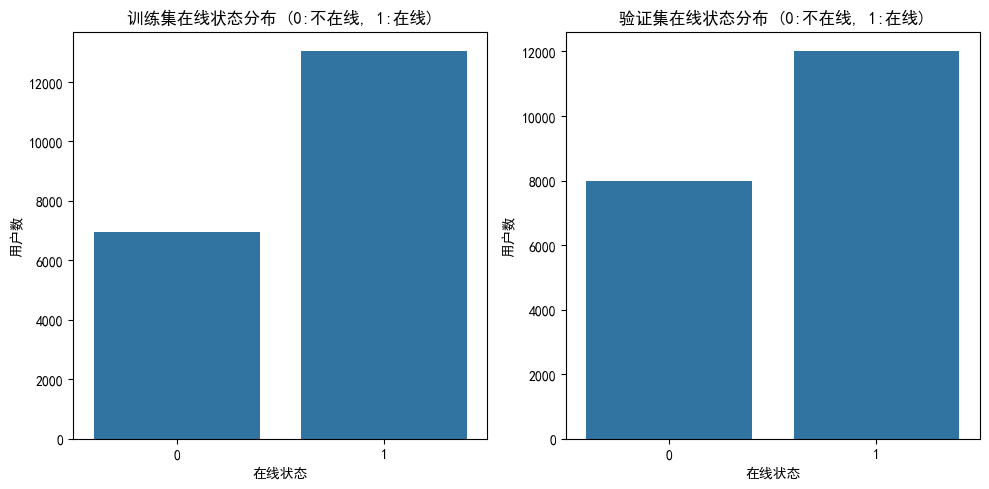


--- Visualizing Distribution of Key Features ---
Plot saved as Key_Feature_Distributions.pdf


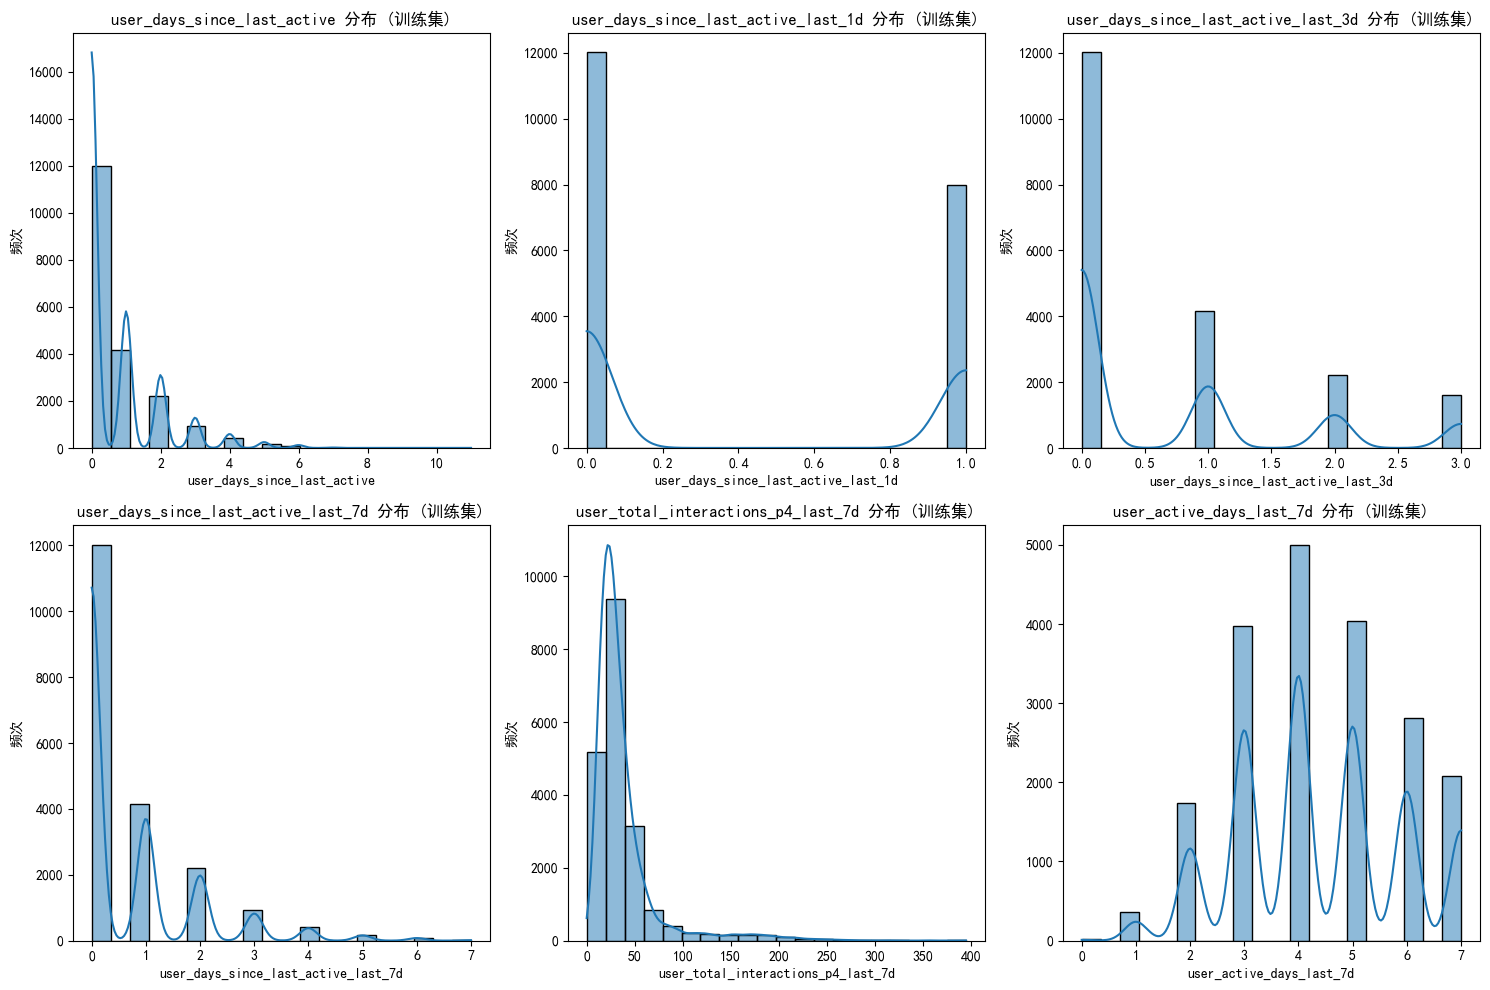

In [13]:
# --- 2. 子任务 1: 训练和预测用户 2024.7.23 是否在线 ---
print("\n--- Building Training and Validation Data for Online Prediction ---")

# 训练集：预测 7.20 是否在线，特征基于 7.11-7.19
print(
    "Processing data for online prediction training (Predicting 7.20 based on 7.11-7.19)..."
)
train_pred_date_online = pd.to_datetime("2024-07-20")
train_hist_end_online = train_pred_date_online - timedelta(days=1)  # 7.19
user_features_train_online_base = create_historical_user_features(
    df_hist, train_hist_end_online
)
# 找到在 7.20 活跃的用户 (训练标签)
active_on_train_date_online = df_hist[df_hist["Date"] == train_pred_date_online][
    "UserID"
].unique()
# 获取所有在历史数据中出现过的用户 + 7.20 活跃的用户，确保标签集包含所有可能的用户
all_users_for_train_label = np.union1d(
    user_features_train_online_base["UserID"].unique(), active_on_train_date_online
)
user_features_train_online = pd.DataFrame({"UserID": all_users_for_train_label})
user_features_train_online = pd.merge(
    user_features_train_online,
    user_features_train_online_base,
    on="UserID",
    how="left",
)  # Left merge to keep all users in label set
user_features_train_online["is_online"] = (
    user_features_train_online["UserID"].isin(active_on_train_date_online).astype(int)
)

# 验证集：预测 7.19 是否在线，特征基于 7.11-7.18
print(
    "Processing data for online prediction validation (Predicting 7.19 based on 7.11-7.18)..."
)
val_pred_date_online = pd.to_datetime("2024-07-19")
val_hist_end_online = val_pred_date_online - timedelta(days=1)  # 7.18
user_features_val_online_base = create_historical_user_features(
    df_hist, val_hist_end_online
)
# 找到在 7.19 活跃的用户 (验证标签)
active_on_val_date_online = df_hist[df_hist["Date"] == val_pred_date_online][
    "UserID"
].unique()
# 获取所有在历史数据中出现过的用户 + 7.19 活跃的用户，确保标签集包含所有可能的用户
all_users_for_val_label = np.union1d(
    user_features_val_online_base["UserID"].unique(), active_on_val_date_online
)
user_features_val_online = pd.DataFrame({"UserID": all_users_for_val_label})
user_features_val_online = pd.merge(
    user_features_val_online, user_features_val_online_base, on="UserID", how="left"
)  # Left merge to keep all users in label set
user_features_val_online["is_online"] = (
    user_features_val_online["UserID"].isin(active_on_val_date_online).astype(int)
)
gc.collect()

# --- 填充在线预测数据的 NaN ---
print(
    "Filling missing values for online training and validation data (distinguishing feature types)..."
)

# 定义一个较大的值，用于填充 days_since 类特征的 NaN
# 历史窗口是 10 天 (7.11-7.20)。训练集参考日期是 7.19，验证集是 7.18。
# 如果用户在整个历史窗口或某个子窗口都没有活动，距离参考日期的天数应该是一个较大的值。
# 使用一个比最大窗口天数 (10) 稍大的值，例如 11。
large_days_value = 11

# 填充训练数据
user_features_train_online = fill_user_features_nan(
    user_features_train_online, large_days_value
)
# 填充验证数据
user_features_val_online = fill_user_features_nan(
    user_features_val_online, large_days_value
)


# 准备训练和验证数据
# 确保训练集和验证集特征列一致
X_train_online = user_features_train_online.drop(columns=["UserID", "is_online"])
y_train_online = user_features_train_online["is_online"]
X_val_online = user_features_val_online.drop(columns=["UserID", "is_online"])
y_val_online = user_features_val_online["is_online"]

# 确保验证集特征列与训练集一致 (处理可能因为历史数据不同导致列不一致的情况)
# 简单方法是只保留训练集中存在的特征列
missing_cols_val = set(X_train_online.columns) - set(X_val_online.columns)
if missing_cols_val:
    print(
        f"Warning: Missing columns in online validation features: {missing_cols_val}. Filling with 0."
    )
    for col in missing_cols_val:
        X_val_online[col] = 0
X_val_online = X_val_online[X_train_online.columns]


print(
    f"Online prediction training data shape: {X_train_online.shape}, labels shape: {y_train_online.shape}"
)
print(
    f"Online prediction validation data shape: {X_val_online.shape}, labels shape: {y_val_online.shape}"
)
gc.collect()

# --- 新增可视化：训练集和验证集标签分布 ---
print("\n--- Visualizing Training and Validation Label Distribution ---")
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train_online)
plt.title('训练集在线状态分布 (0:不在线, 1:在线)')
plt.xlabel('在线状态')
plt.ylabel('用户数')

plt.subplot(1, 2, 2)
sns.countplot(x=y_val_online)
plt.title('验证集在线状态分布 (0:不在线, 1:在线)')
plt.xlabel('在线状态')
plt.ylabel('用户数')

plt.tight_layout()
pdf_filename_label_dist = "Online_Prediction_Label_Distribution.pdf"
plt.savefig(pdf_filename_label_dist, format='pdf', bbox_inches='tight')
print(f"Plot saved as {pdf_filename_label_dist}")
plt.show()

# --- 新增可视化：部分重要特征的分布 (例如 days_since_last_active) ---
print("\n--- Visualizing Distribution of Key Features ---")
key_features = [
    'user_days_since_last_active',
    'user_days_since_last_active_last_1d',
    'user_days_since_last_active_last_3d',
    'user_days_since_last_active_last_7d',
    'user_total_interactions_p4_last_7d',
    'user_active_days_last_7d'
]
plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_features):
    if feature in X_train_online.columns:
        plt.subplot(2, 3, i + 1)
        sns.histplot(X_train_online[feature], kde=True, bins=20)
        plt.title(f'{feature} 分布 (训练集)')
        plt.xlabel(feature)
        plt.ylabel('频次')
plt.tight_layout()
pdf_filename_feature_dist = "Key_Feature_Distributions.pdf"
plt.savefig(pdf_filename_feature_dist, format='pdf', bbox_inches='tight')
print(f"Plot saved as {pdf_filename_feature_dist}")
plt.show()




--- Training LightGBM Classifier for Online Prediction ---
Starting online model fitting...
Online model training finished.

--- Visualizing Online Model Feature Importance ---
Plot saved as Online_Model_Feature_Importance.pdf


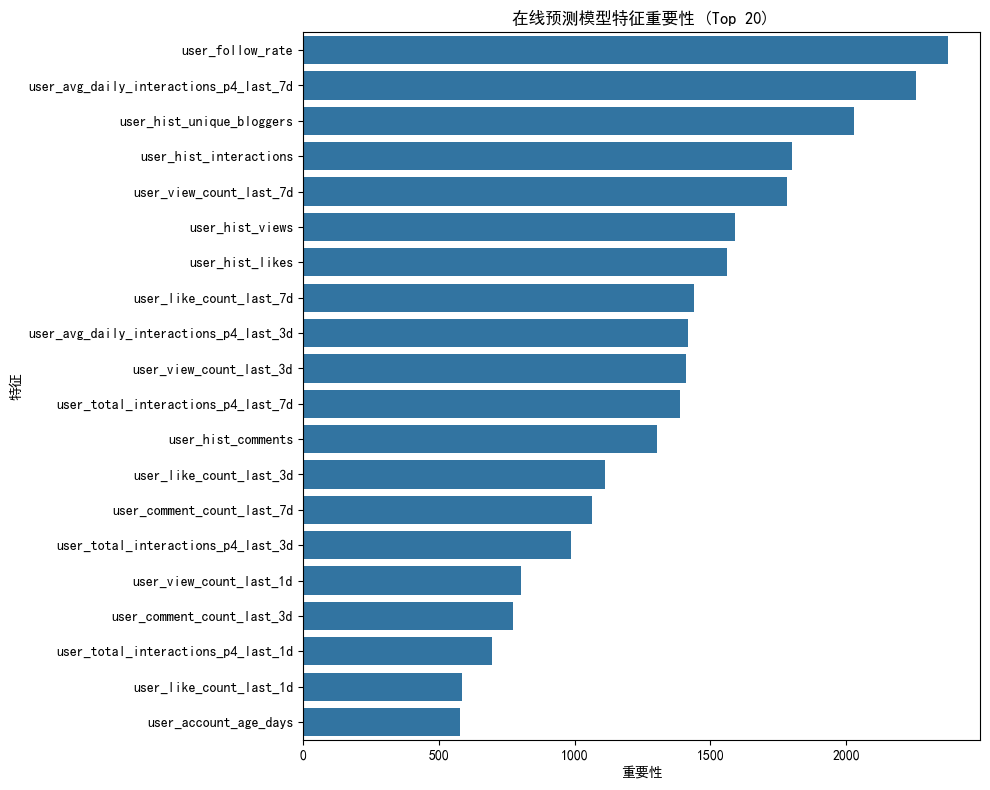

In [14]:
print("\n--- Training LightGBM Classifier for Online Prediction ---")
# 定义模型参数
online_lgb_params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": -1,
    "n_estimators": 1000,
    "n_jobs": -1,
    "seed": 42,
    "is_unbalance": True,  # 如果正负样本不平衡可以尝试开启
}
online_model = lgb.LGBMClassifier(**online_lgb_params)
print("Starting online model fitting...")
# 在训练集上训练模型
online_model.fit(X_train_online, y_train_online)
print("Online model training finished.")

# --- 新增可视化：在线预测模型特征重要性 ---
print("\n--- Visualizing Online Model Feature Importance ---")
feature_importance = pd.DataFrame({
    'feature': X_train_online.columns,
    'importance': online_model.feature_importances_
}).sort_values('importance', ascending=False).head(20) # 只显示前20个重要特征

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('在线预测模型特征重要性 (Top 20)')
plt.xlabel('重要性')
plt.ylabel('特征')
plt.tight_layout()
pdf_filename_feature_imp = "Online_Model_Feature_Importance.pdf"
plt.savefig(pdf_filename_feature_imp, format='pdf', bbox_inches='tight')
print(f"Plot saved as {pdf_filename_feature_imp}")
plt.show()




--- Evaluating Online Model on Validation Set and Selecting Threshold ---
Calculating metrics for different thresholds...


Evaluating Thresholds:   0%|          | 0/101 [00:00<?, ?it/s]


Best threshold for F1-score on validation set: 0.2078
F1-score at this threshold: 0.7512
Precision at this threshold: 0.6058
Recall at this threshold: 0.9885

Best threshold for Recall >= 0.70 and max Precision: 0.5109
Precision: 0.6722, Recall: 0.7052

Plot saved as Online_Prediction_Metrics_vs_Threshold_Validation_Set.pdf

Plot saved as online_prediction_pr_curve.pdf


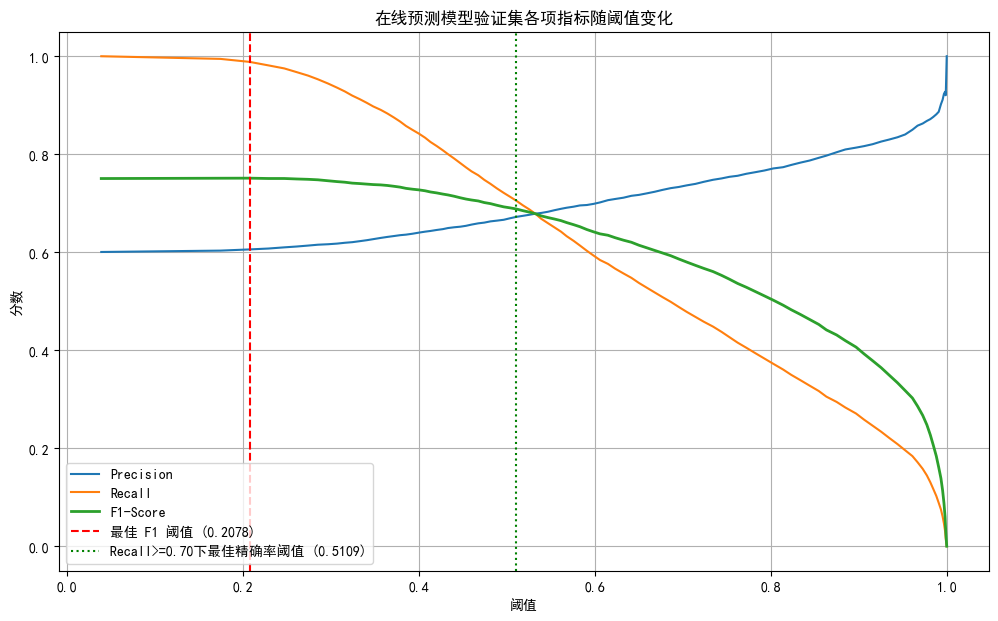

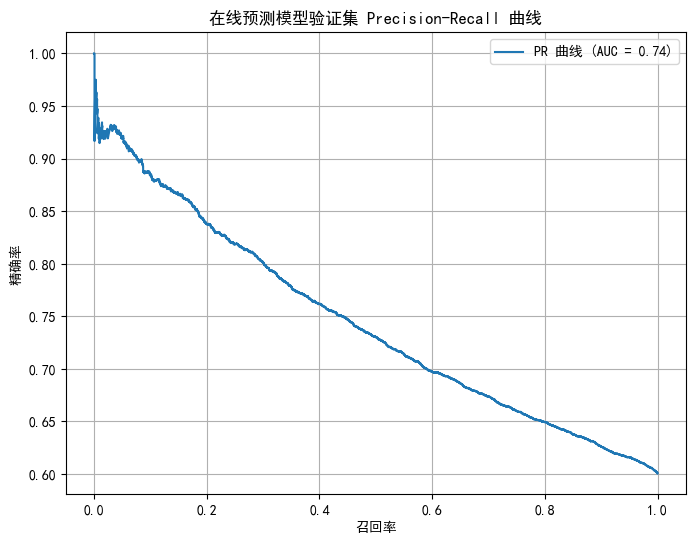

In [15]:
# --- 在验证集上评估并选择最佳阈值 ---
print("\n--- Evaluating Online Model on Validation Set and Selecting Threshold ---")
# 在验证集上预测概率
y_pred_proba_val_online = online_model.predict_proba(X_val_online)[:, 1]
# 计算 Precision, Recall, F1-Score 随阈值变化
# 考虑样本不平衡，从预测概率中选取一些分位数作为候选阈值可能更有效
# thresholds = np.arange(0.01, 1.0, 0.01) # Original range, might be too sparse or dense
# Let's use percentiles for thresholds, ensuring we cover the range of probabilities
thresholds = np.percentile(
    y_pred_proba_val_online, np.arange(0, 101, 1)
)  # Use 0 to 100 percentiles
thresholds = np.sort(np.unique(thresholds))  # Ensure thresholds are sorted and unique

precisions = []
recalls = []
f1_scores = []
print("Calculating metrics for different thresholds...")
for thresh in tqdm(thresholds, desc="Evaluating Thresholds"):
    # 将概率按当前阈值转换为 0/1 预测
    y_pred_binary_val = (y_pred_proba_val_online >= thresh).astype(int)
    # 计算指标 (注意 zero_division=0 避免除以零警告)
    precisions.append(precision_score(y_val_online, y_pred_binary_val, zero_division=0))
    recalls.append(recall_score(y_val_online, y_pred_binary_val, zero_division=0))
    f1_scores.append(f1_score(y_val_online, y_pred_binary_val, zero_division=0))

# 找到最佳阈值 (例如，使 F1 分数最高的阈值)
best_f1_idx = np.argmax(f1_scores)
best_threshold_f1 = thresholds[best_f1_idx]
print(f"\nBest threshold for F1-score on validation set: {best_threshold_f1:.4f}")
print(f"F1-score at this threshold: {f1_scores[best_f1_idx]:.4f}")
print(f"Precision at this threshold: {precisions[best_f1_idx]:.4f}")
print(f"Recall at this threshold: {recalls[best_f1_idx]:.4f}")

# 也可以考虑一个最小召回率下的最大精确率阈值
min_recall_target = 0.7  # 可以根据实际情况调整，例如确保能覆盖大部分在线用户
valid_threshold_indices = [i for i, r in enumerate(recalls) if r >= min_recall_target]
if valid_threshold_indices:
    # 在满足最小召回率的阈值中，找到精确率最高的那个
    best_precision_idx = valid_threshold_indices[
        np.argmax(np.array(precisions)[valid_threshold_indices])
    ]
    best_threshold_prec_recall = thresholds[best_precision_idx]
    print(
        f"\nBest threshold for Recall >= {min_recall_target:.2f} and max Precision: {best_threshold_prec_recall:.4f}"
)
    print(
        f"Precision: {precisions[best_precision_idx]:.4f}, Recall: {recalls[best_precision_idx]:.4f}"
    )
    # 使用这个阈值作为最终阈值
    final_online_prediction_threshold = best_threshold_prec_recall
else:
    print(
        f"\nCould not find a threshold meeting the minimum Recall requirement of {min_recall_target:.2f}. Using best F1 threshold."
    )
    # 如果没有满足最低召回率的阈值，回退到使用最佳 F1 阈值
    final_online_prediction_threshold = best_threshold_f1


# 可视化指标随阈值变化
plt.figure(figsize=(12, 7))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1_scores, label="F1-Score", linewidth=2)
plt.xlabel("阈值")
plt.ylabel("分数")
plt.title("在线预测模型验证集各项指标随阈值变化")
plt.axvline(
    best_threshold_f1,
    color="red",
    linestyle="--",
    label=f"最佳 F1 阈值 ({best_threshold_f1:.4f})",
)  # Updated formatting
if valid_threshold_indices:
    plt.axvline(
        best_threshold_prec_recall,
        color="green",
        linestyle=":",
        label=f"Recall>={min_recall_target:.2f}下最佳精确率阈值 ({best_threshold_prec_recall:.4f})",
    )  # Updated formatting
plt.legend()
plt.grid(True)

pdf_filename_online_metrics = (
    "Online_Prediction_Metrics_vs_Threshold_Validation_Set.pdf"
)
plt.savefig(pdf_filename_online_metrics, format="pdf", bbox_inches="tight")
print(f"\nPlot saved as {pdf_filename_online_metrics}")

# 绘制 PR 曲线
precision_pr, recall_pr, _ = precision_recall_curve(
    y_val_online, y_pred_proba_val_online
)
auc_pr = auc(recall_pr, precision_pr)
plt.figure(figsize=(8, 6))
plt.plot(recall_pr, precision_pr, label=f"PR 曲线 (AUC = {auc_pr:.2f})")
plt.xlabel("召回率")
plt.ylabel("精确率")
plt.title("在线预测模型验证集 Precision-Recall 曲线")
plt.legend()
plt.grid(True)
pdf_filename_online_pr = "online_prediction_pr_curve.pdf"
plt.savefig(pdf_filename_online_pr, format="pdf", bbox_inches="tight")
print(f"\nPlot saved as {pdf_filename_online_pr}")
plt.show()
plt.close("all")



In [16]:
# --- 使用选择的最佳阈值进行 7.23 在线预测 ---
print(
    f"\nUsing final online prediction threshold: {final_online_prediction_threshold:.4f}"
)
print("\n--- Predicting 7.23 Online Status for Target Users ---")
# 为目标用户计算基于 7.11-7.20 的特征 (预测 7.23 需要截止到 7.22 的特征，但附件1只有到 7.20)
# 严格按照附件1数据进行预测，所以特征截止日期是 7.20
predict_online_users_df = pd.DataFrame({"UserID": target_users_p4})
print(
    f"Calculating historical features for target users (up to {hist_end_date.date()})..."
)
# 使用 create_historical_user_features 函数，参考日期是历史数据结束日期 7.20
predict_online_features_calc = create_historical_user_features(df_hist, hist_end_date)
# 合并目标用户列表与计算出的特征 (使用 left merge 保留所有目标用户)
predict_online_features = pd.merge(
    predict_online_users_df, predict_online_features_calc, on="UserID", how="left"
)

# --- 填充预测数据的 NaN ---
print(
    "Filling missing values for target user prediction features (distinguishing feature types)..."
)
predict_online_features = fill_user_features_nan(
    predict_online_features, large_days_value
)


# 确保预测特征列与训练特征列一致且顺序相同
# 只保留训练集中存在的特征列
missing_cols_pred = set(X_train_online.columns) - set(predict_online_features.columns)
if missing_cols_pred:
    print(
        f"Warning: Missing columns in online prediction features: {missing_cols_pred}. Filling with 0."
    )
    for col in missing_cols_pred:
        predict_online_features[col] = 0

# 确保列顺序一致
predict_online_features = predict_online_features[X_train_online.columns]




Using final online prediction threshold: 0.5109

--- Predicting 7.23 Online Status for Target Users ---
Calculating historical features for target users (up to 2024-07-20)...
Filling missing values for target user prediction features (distinguishing feature types)...


In [17]:
# 预测在线概率
online_pred_proba = online_model.predict_proba(predict_online_features)[:, 1]
predict_online_users_df["online_proba"] = online_pred_proba
# 根据选择的阈值判断是否在线
predict_online_users_df["predicted_online_7.23"] = (
    predict_online_users_df["online_proba"] >= final_online_prediction_threshold
).astype(int)

predicted_online_users_p4 = predict_online_users_df[
    predict_online_users_df["predicted_online_7.23"] == 1
]["UserID"].tolist()

print(f"Predicted {len(predicted_online_users_p4)} target users to be online on 7.23.")
print(f"Predicted online users for Problem 4: {predicted_online_users_p4}")
gc.collect()



Predicted 3 target users to be online on 7.23.
Predicted online users for Problem 4: ['U10', 'U1833', 'U26447']


4


Plot saved as Online_Probability_for_Selected_Users_7_23.pdf


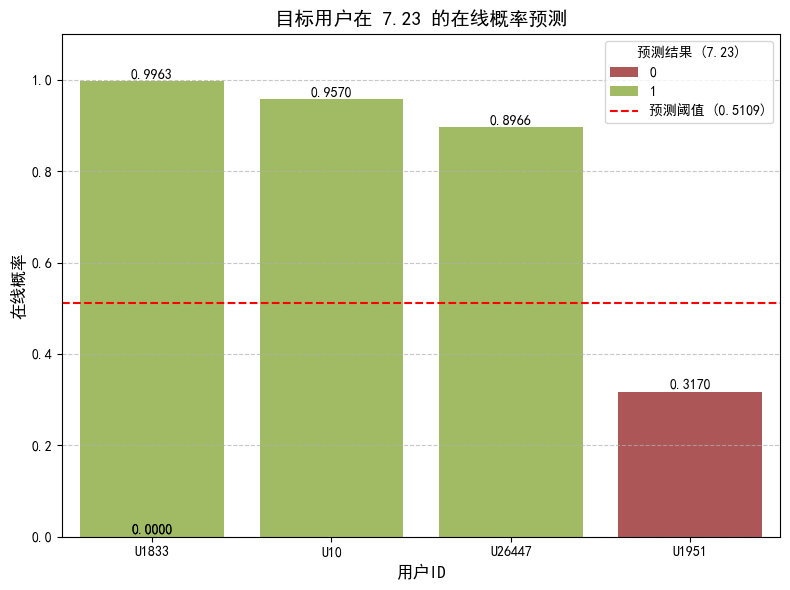

In [18]:
# 可视化目标用户 7.23 在线概率
data = {
    "UserID": target_users_p4,  # 使用原始目标用户列表
    "online_proba": online_pred_proba,
    "predicted_online": predict_online_users_df[
        "predicted_online_7.23"
    ].tolist(),  # Add prediction result for color coding
}
df_online_proba_viz = pd.DataFrame(data)

# 为了让图表更清晰，按概率降序排序
df_sorted_proba = df_online_proba_viz.sort_values(by="online_proba", ascending=False)

# 创建图表和轴对象
plt.figure(figsize=(8, 6))
# 使用 seaborn 的 barplot，并根据预测结果着色
ax = sns.barplot(
    x="UserID",
    y="online_proba",
    hue="predicted_online",
    data=df_sorted_proba,
    palette={1: "#a7c957", 0: "#bc4749"}, # 使用更直观的颜色区分预测在线/不在线
    dodge=False,  # dodge=False to prevent bars from splitting
)

# 添加标题和轴标签
plt.title("目标用户在 7.23 的在线概率预测", fontsize=14)
plt.xlabel("用户ID", fontsize=12)
plt.ylabel("在线概率", fontsize=12)
plt.ylim(0, 1.1)
plt.axhline(
    final_online_prediction_threshold,
    color="red",
    linestyle="--",
    label=f"预测阈值 ({final_online_prediction_threshold:.4f})",
)
plt.legend(title="预测结果 (7.23)")

# 在每个柱子上方显示具体的概率值
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.4f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 5),
        textcoords="offset points",
    )

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

pdf_filename_online_proba = "Online_Probability_for_Selected_Users_7_23.pdf"
plt.savefig(pdf_filename_online_proba, format="pdf", bbox_inches="tight")
print(f"\nPlot saved as {pdf_filename_online_proba}")
plt.show()
plt.close("all")




--- Predicting Top 3 Active Hours and Bloggers for Predicted Online Users ---
Initialized result table with index: ['U10', 'U1951', 'U1833', 'U26447']
Analyzing historical behavior for predicted online users...


/var/folders/f_/c214vm4j6sb183tqrqmgczwc0000gn/T/ipykernel_85389/3454411570.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_hours_online_users = hourly_counts.groupby('UserID', group_keys=False).apply(lambda g: g.nlargest(3, 'prob')).reset_index(drop=True)


Identified Top 3 hours for 19998 predicted online users.
Calculated interaction counts for 19318068 predicted online user-hour-blogger pairs.


/var/folders/f_/c214vm4j6sb183tqrqmgczwc0000gn/T/ipykernel_85389/3454411570.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_bloggers_per_hour_online = merged_interactions_online.groupby(['UserID', 'Hour'], group_keys=False).apply(


Populating result table for predicted online users...

--- Problem 4 Result ---
| 用户ID   | 博主ID 1   | 时段1       | 博主ID 2   | 时段2       | 博主ID 3   | 时段3       |
|:---------|:-----------|:------------|:-----------|:------------|:-----------|:------------|
| U10      | B2         | 02:00-03:00 | B2         | 15:00-16:00 | B23        | 16:00-17:00 |
| U1951    |            |             |            |             |            |             |
| U1833    | B19        | 01:00-02:00 | B15        | 03:00-04:00 | B16        | 11:00-12:00 |
| U26447   | B13        | 02:00-03:00 | B13        | 15:00-16:00 | B13        | 20:00-21:00 |

Problem 4 result saved to '问题4_结果.csv'

--- Visualizing Hourly Distribution for Predicted Online Users (Historical) ---
Plot saved as Predicted_Online_Users_Historical_Hourly_Distribution.pdf


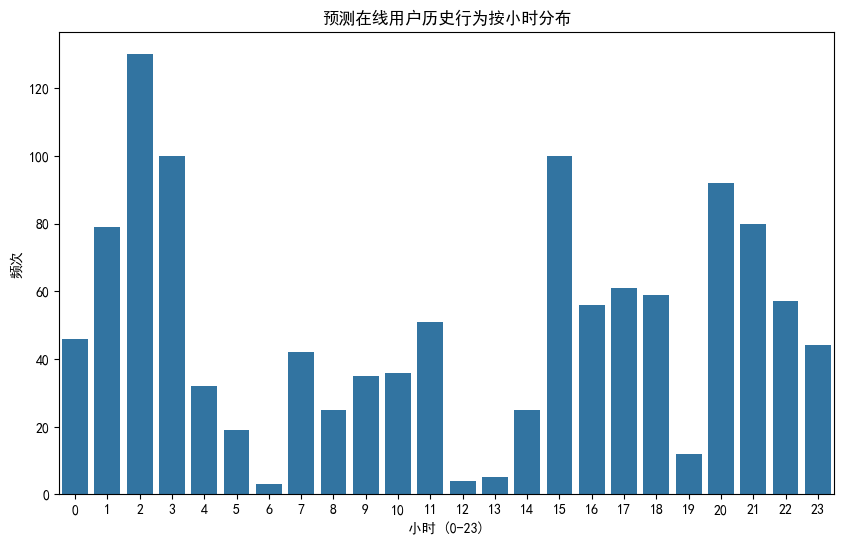


--- Visualizing Top Bloggers for Predicted Online Users (Historical) ---
Plot saved as Predicted_Online_Users_Historical_Top_Bloggers.pdf


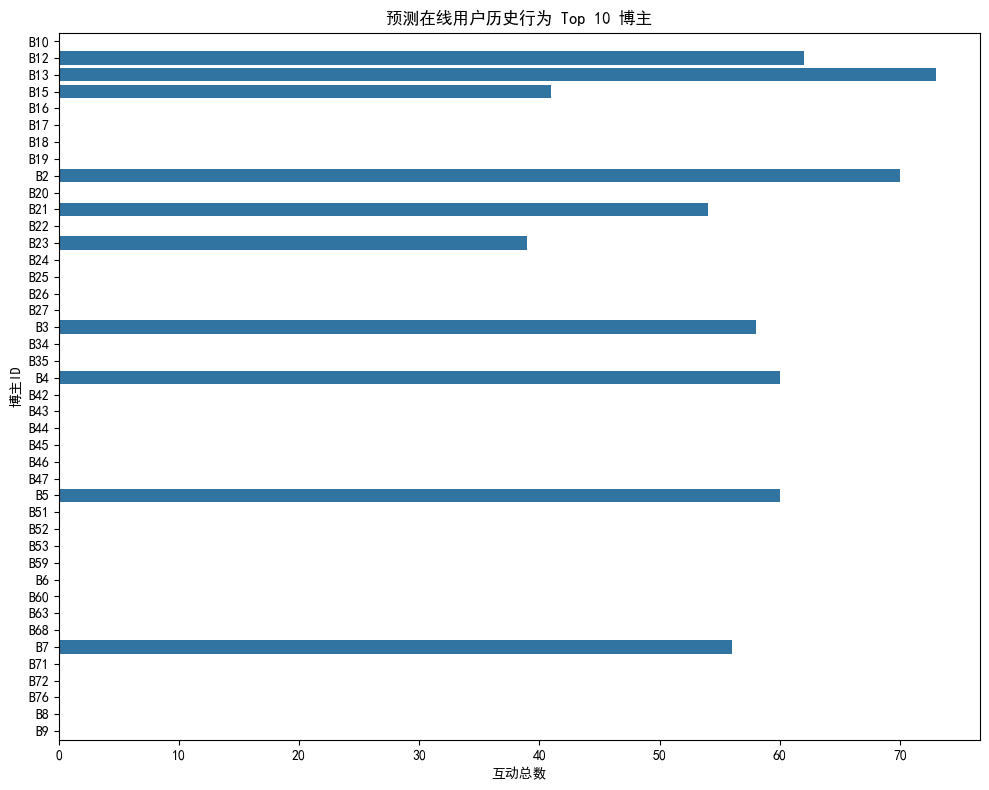

293

In [19]:
# --- 3. Subtask 2: Predict Active Time Slots and Bloggers for Online Users ---
print("\n--- Predicting Top 3 Active Hours and Bloggers for Predicted Online Users ---")

# Initialize the result table with all target users and empty strings
result_table_p4_list = []
for user_id in target_users_p4:
    row = {'用户ID': user_id}
    for i in range(1, 4):
        row[f'博主ID {i}'] = ''
        row[f'时段{i}'] = ''
    result_table_p4_list.append(row)

result_table_p4 = pd.DataFrame(result_table_p4_list)

# --- FIX: Set UserID as index BEFORE populating ---
# Setting UserID as index allows direct label-based assignment with .loc
result_table_p4 = result_table_p4.set_index('用户ID')
print(f"Initialized result table with index: {result_table_p4.index.tolist()}") # Debug print


# Only proceed with detailed prediction if there are predicted online users
if not predicted_online_users_p4:
    print("No target users predicted to be online on 7.23. Result table contains empty values.")
else:
    # Filter historical data (7.11-7.20) for the predicted online users
    df_online_hist = df_hist[df_hist['UserID'].isin(predicted_online_users_p4)].copy()

    if df_online_hist.empty:
         print("Predicted online users have no historical data (7.11-7.20). Cannot predict time slots and bloggers.")
         # Result table will remain with empty strings as initialized
    else:
        print("Analyzing historical behavior for predicted online users...")

        # Step 3.1：获取每个用户 Top3 小时段（按行为频率）
        hourly_counts = df_online_hist.groupby(['UserID', 'Hour']).size().reset_index(name='count')
        hourly_counts['prob'] = hourly_counts.groupby('UserID')['count'].transform(lambda x: x / x.sum())
        top_hours_online_users = hourly_counts.groupby('UserID', group_keys=False).apply(lambda g: g.nlargest(3, 'prob')).reset_index(drop=True)
        top_hours_online_users = top_hours_online_users[['UserID', 'Hour']]
        print(f"Identified Top 3 hours for {top_hours_online_users['UserID'].nunique()} predicted online users.")

        # Step 3.2：统计每个 用户-小时-博主 的互动数 (点赞+评论+关注)
        interaction_behaviors_p4 = [2, 3, 4]
        interaction_hist_online = df_online_hist[df_online_hist['UserBehaviour'].isin(interaction_behaviors_p4)].copy()
        if not interaction_hist_online.empty:
             ub_hourly_interactions_online = interaction_hist_online.groupby(['UserID', 'Hour', 'BloggerID']).size().reset_index(name='interaction_count')
        else:
             print("No interaction data (like, comment, follow) for predicted online users in history. Cannot predict bloggers.")
             ub_hourly_interactions_online = pd.DataFrame(columns=['UserID', 'Hour', 'BloggerID', 'interaction_count'])
        print(f"Calculated interaction counts for {len(ub_hourly_interactions_online)} predicted online user-hour-blogger pairs.")

        # Step 3.3：Combine Top hours and interaction counts to find best blogger per hour
        merged_interactions_online = pd.merge(
            top_hours_online_users,
            ub_hourly_interactions_online,
            on=['UserID', 'Hour'],
            how='left'
        )
        top_bloggers_per_hour_online = merged_interactions_online.groupby(['UserID', 'Hour'], group_keys=False).apply(
            lambda g: g.nlargest(1, 'interaction_count', keep='first')
        ).reset_index(drop=True)

        # --- Populate the result_table_p4 ---
        print("Populating result table for predicted online users...")

        # Collect results per user and hour from top_bloggers_per_hour_online
        user_hour_blogger_dict = {}
        if not top_bloggers_per_hour_online.empty:
            for user_id, hour, blogger_id, interaction_count in top_bloggers_per_hour_online[['UserID', 'Hour', 'BloggerID', 'interaction_count']].itertuples(index=False):
                if user_id not in user_hour_blogger_dict:
                    user_hour_blogger_dict[user_id] = []
                # Store as tuple (hour, blogger_id, interaction_count)
                user_hour_blogger_dict[user_id].append((hour, blogger_id, interaction_count))

            # Sort results for each user by hour
            for user_id in user_hour_blogger_dict:
                user_hour_blogger_dict[user_id].sort(key=lambda x: x[0]) # Sort by hour

            # Populate the result_table_p4 using the UserID index
            # Iterate through users who have prediction results
            for user_id, results_list in user_hour_blogger_dict.items():
                 # --- FIX: Use .loc with the user_id label directly ---
                 # Ensure user_id exists in the index before using .loc
                 if user_id in result_table_p4.index:
                     # Fill the predicted results (up to 3)
                     for i in range(min(3, len(results_list))):
                         hour, blogger_id, interaction_count = results_list[i]

                         # Only fill if there was actual interaction count (not NaN from left merge) and interaction_count > 0
                         if pd.notna(blogger_id) and pd.notna(interaction_count) and interaction_count > 0:
                              # Use .loc with the user_id LABEL (index)
                              result_table_p4.loc[user_id, f'博主ID {i+1}'] = str(blogger_id) # Ensure it's a string
                              result_table_p4.loc[user_id, f'时段{i+1}'] = f"{int(hour):02}:00-{int(hour)+1:02}:00" # Format hour with leading zero
                         # If interaction_count is 0 or NaN, the column remains the initial empty string ''
                 else:
                     print(f"Warning: User {user_id} has prediction results but is not in the target user list {target_users_p4}. Skipping.") # Should not happen if logic is correct

        else:
             print("No top bloggers found for any predicted online user based on historical interactions.")
             # result_table_p4 remains with empty strings as initialized


# --- 4. Output Problem 4 Result ---
print("\n--- Problem 4 Result ---")

# --- FIX: Reset index AFTER populating ---
# Reset the index back to a column for final output
result_table_p4 = result_table_p4.reset_index()

# Ensure the output table only contains the specified columns in order
output_cols = ['用户ID', '博主ID 1', '时段1', '博主ID 2', '时段2', '博主ID 3', '时段3']
# Ensure all columns exist in case some weren't populated (e.g., if no online users)
for col in output_cols:
    if col not in result_table_p4.columns:
        result_table_p4[col] = '' # Add missing columns with empty strings

result_table_p4 = result_table_p4[output_cols] # Ensure order and drop potential extra columns

# Convert any potential remaining pd.NA to '' just in case (shouldn't happen with the new initialization/filling logic, but for safety)
result_table_p4 = result_table_p4.fillna('')


print(result_table_p4.to_markdown(index=False))

# Save result to CSV
result_table_p4.to_csv("问题4_结果.csv", index=False, encoding='utf-8-sig')
print("\nProblem 4 result saved to '问题4_结果.csv'")

# --- 新增可视化：预测在线用户的历史行为小时分布 (Problem 4) ---
if not df_online_hist.empty:
    print("\n--- Visualizing Hourly Distribution for Predicted Online Users (Historical) ---")
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Hour', data=df_online_hist, order=sorted(df_online_hist['Hour'].unique()))
    plt.title('预测在线用户历史行为按小时分布')
    plt.xlabel('小时 (0-23)')
    plt.ylabel('频次')
    pdf_filename_online_user_hourly = "Predicted_Online_Users_Historical_Hourly_Distribution.pdf"
    plt.savefig(pdf_filename_online_user_hourly, format='pdf', bbox_inches='tight')
    print(f"Plot saved as {pdf_filename_online_user_hourly}")
    plt.show()

    # --- 新增可视化：预测在线用户历史行为 Top N 博主 (Problem 4) ---
    print("\n--- Visualizing Top Bloggers for Predicted Online Users (Historical) ---")
    # 统计所有互动行为 (浏览、点赞、评论、关注)
    blogger_counts_online = df_online_hist.groupby('BloggerID').size().reset_index(name='count')
    top_n_bloggers = blogger_counts_online.nlargest(10, 'count') # 可以调整 N 的大小

    if not top_n_bloggers.empty:
        plt.figure(figsize=(10, 8))
        sns.barplot(x='count', y='BloggerID', data=top_n_bloggers)
        plt.title(f'预测在线用户历史行为 Top {len(top_n_bloggers)} 博主')
        plt.xlabel('互动总数')
        plt.ylabel('博主ID')
        plt.tight_layout()
        pdf_filename_online_user_bloggers = "Predicted_Online_Users_Historical_Top_Bloggers.pdf"
        plt.savefig(pdf_filename_online_user_bloggers, format='pdf', bbox_inches='tight')
        print(f"Plot saved as {pdf_filename_online_user_bloggers}")
        plt.show()
    else:
        print("No blogger interaction data available for visualization for predicted online users.")


gc.collect()


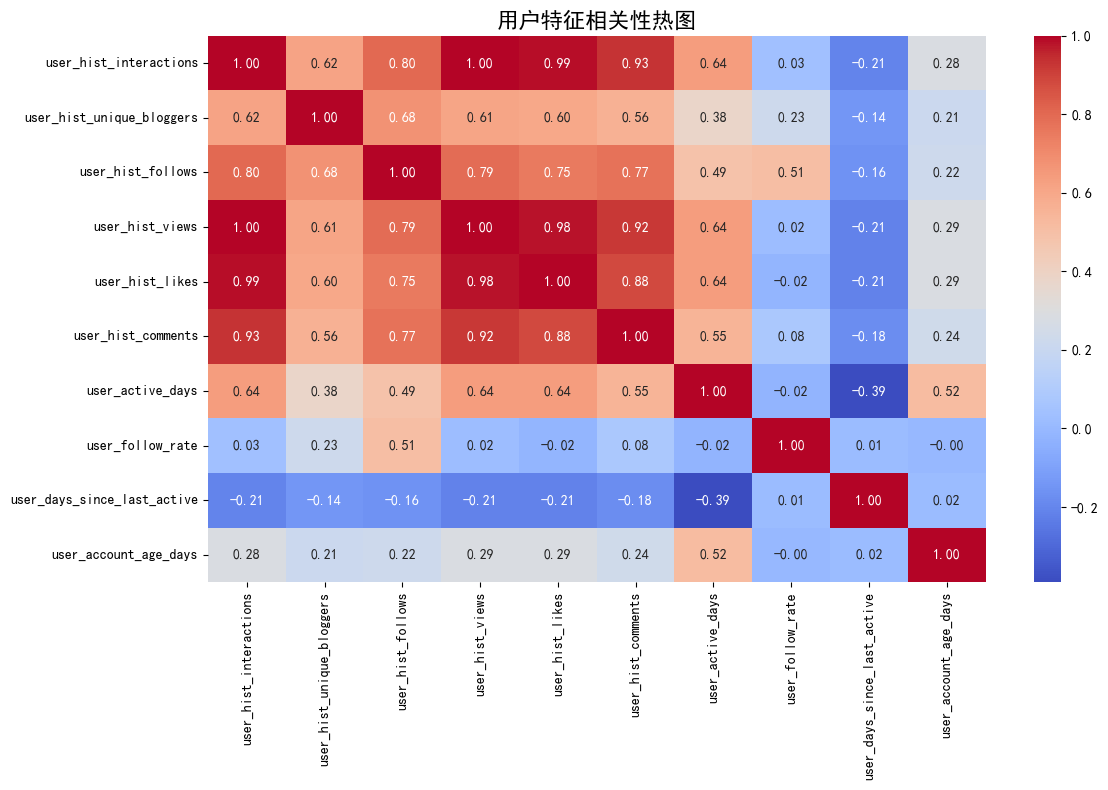

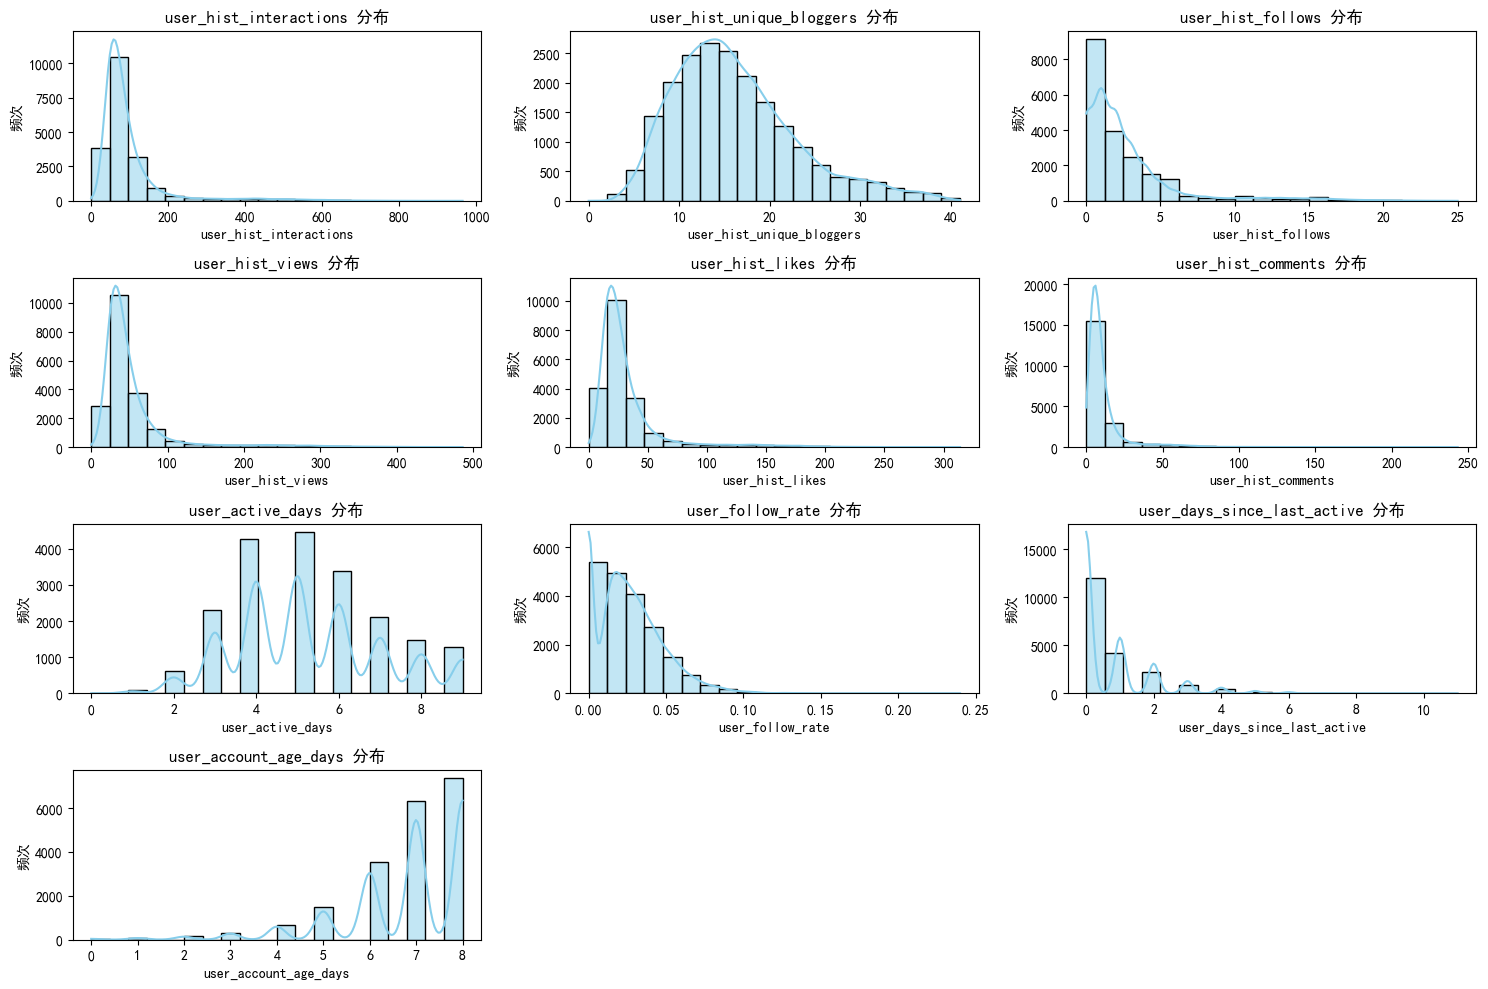

In [28]:
import seaborn as sns

# --- 可视化用户特征的相关性和分布 ---
import matplotlib.pyplot as plt

# 选择一些数值型特征进行分析
selected_features = [
    "user_hist_interactions",
    "user_hist_unique_bloggers",
    "user_hist_follows",
    "user_hist_views",
    "user_hist_likes",
    "user_hist_comments",
    "user_active_days",
    "user_follow_rate",
    "user_days_since_last_active",
    "user_account_age_days",
]

# 过滤出这些特征的子集
user_features_subset = user_features_train_online[selected_features]

# --- 热图 1: 特征相关性 ---
plt.figure(figsize=(12, 8))
correlation_matrix = user_features_subset.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("用户特征相关性热图", fontsize=16)
plt.tight_layout()
plt.savefig("用户特征相关性热图.pdf", format='pdf', bbox_inches='tight')
plt.show()

# --- 热图 2: 用户特征分布 ---
plt.figure(figsize=(15, 10))
for i, feature in enumerate(selected_features):
    plt.subplot(4, 3, i + 1)
    sns.histplot(user_features_train_online[feature], kde=True, bins=20, color="skyblue")
    plt.title(f"{feature} 分布", fontsize=12)
    plt.xlabel(feature, fontsize=10)
    plt.ylabel("频次", fontsize=10)
plt.tight_layout()
plt.savefig("用户特征分布热图.pdf", format='pdf', bbox_inches='tight')
plt.show()